# Time Series Analysis

**Goal:** do a complete time series decomposition on a straightforward dataset.

We want to separate the following components of a time series:

- trend (linear or exponential)
- seasonality
- random noise
- other (related to autocorrelation, if any)

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df = sns.load_dataset("flights")
df.head(3)

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132


<Axes: >

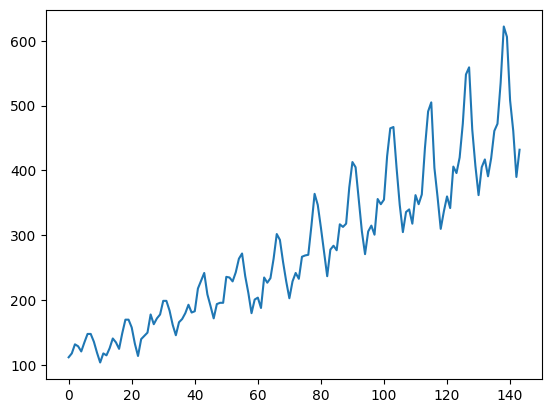

In [3]:
df["passengers"].plot()

### Create nice timestamps for the x-axis

In [8]:
ts = pd.to_datetime(
    df["year"].astype(str) + "-" + df["month"].astype(str) + "-01"
)

In [72]:
# pandas is super good at handling timestamps in different formats!
pd.date_range(start="Nov 5th, 2025 at 9:40", freq="7min 10s", periods=10)

DatetimeIndex(['2025-11-05 09:40:00', '2025-11-05 09:47:10',
               '2025-11-05 09:54:20', '2025-11-05 10:01:30',
               '2025-11-05 10:08:40', '2025-11-05 10:15:50',
               '2025-11-05 10:23:00', '2025-11-05 10:30:10',
               '2025-11-05 10:37:20', '2025-11-05 10:44:30'],
              dtype='datetime64[ns]', freq='430s')

In [9]:
df = df.set_index(ts)
# df.set_index(ts, inplace=True)
df.head(3)

,year,month,passengers
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132


<Axes: >

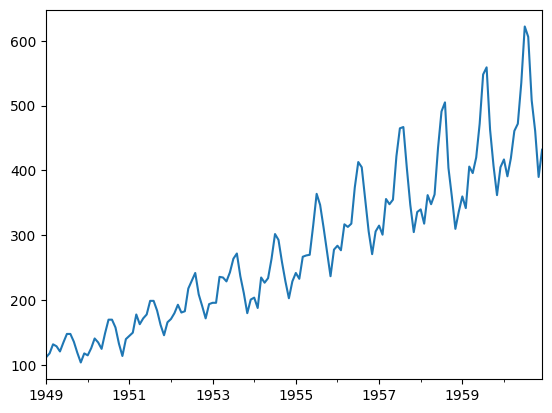

In [10]:
df["passengers"].plot()

### Remove the trend

diff() removes a linear trend

In [19]:
df["diff"] = df["passengers"].diff()  # linear trend
df["diff"].mean()  # data grows by that many passengers per month on average

np.float64(2.237762237762238)

<Axes: >

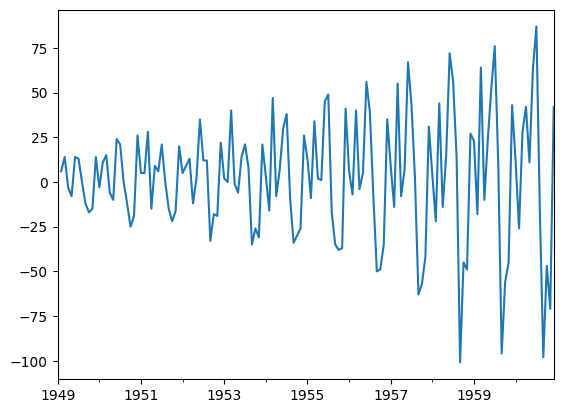

In [20]:
df["diff"].plot()

**heteroscedasticity**: the variance of the data is not the same everywhere -> assuming linear growth is a bad idea

Let's try an exponential trend instead

There are two alternatives: log + diff or percentage change. The latter is more common in time series analysis, there is a subtle mathematical difference realted to the evenly spaced discrete x-axis in time series.

In [23]:
# alternative: log(x+1)
import numpy as np

df["log1p"] = np.log1p(df["passengers"])
df["pct"] = df["passengers"].pct_change()   # percent change, similar to log + diff

In [27]:
#df["log1p"].diff().plot()
df["pct"].mean()  # grows on average by 1.5% per month

np.float64(0.015168535658176796)

<Axes: >

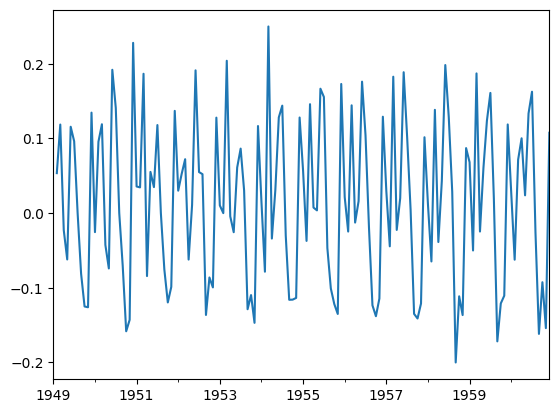

In [28]:
df["pct"].plot()  # now we have homoscedasticity - the seasonal pattern is clearly visible

### Remove seasonality

<Axes: xlabel='month'>

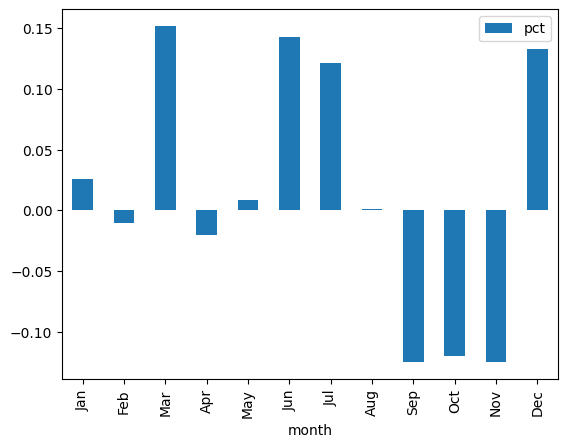

In [34]:
monthly_means = pd.pivot_table(data=df, index="month", values="pct", aggfunc="mean", observed=True)
monthly_means.plot.bar()

In [42]:
# concatenate the data 12 times with itself
mm = list(monthly_means.values[:,0]) * 12
len(mm), df.shape

(144, (144, 6))

In [44]:
df["mm"] = mm
df["unseasoned"] = df["pct"] - df["mm"]
df.head()

,year,month,passengers,diff,log1p,pct,mm,unseasoned
1949-01-01,1949,Jan,112,NaN,4.727388,NaN,0.025745,NaN
1949-02-01,1949,Feb,118,6.0,4.779123,0.053571,-0.010453,0.064024
1949-03-01,1949,Mar,132,14.0,4.890349,0.118644,0.151735,-0.033091
1949-04-01,1949,Apr,129,-3.0,4.867534,-0.022727,-0.020056,-0.002671
1949-05-01,1949,May,121,-8.0,4.804021,-0.062016,0.008571,-0.070587


### Noise

We want to know if there is any information remaining in the data. 
If not, we are done.

<Axes: >

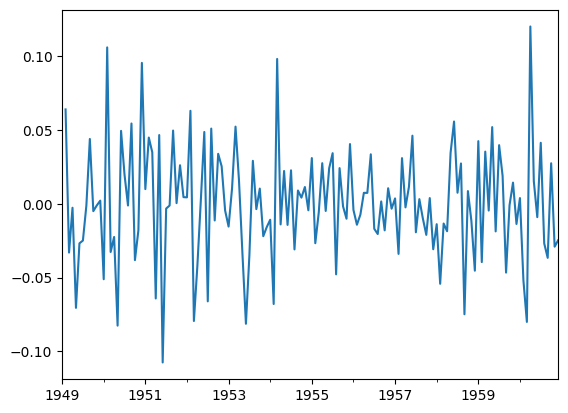

In [45]:
df["unseasoned"].plot()

<Axes: >

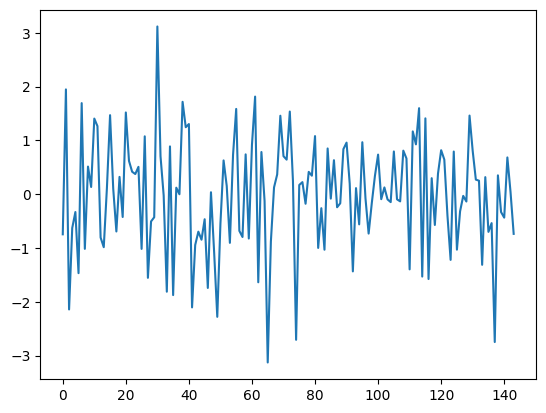

In [53]:
# normally distributed random noise for comparison
a = np.random.normal(size=144)
pd.Series(a).plot()

In [48]:
# options to test whether this is normally distributed
# a) histogram
# b) QQ-plot
# c) run a statistical test (nah... we probably don't have enough data for that)

<Axes: xlabel='unseasoned', ylabel='Count'>

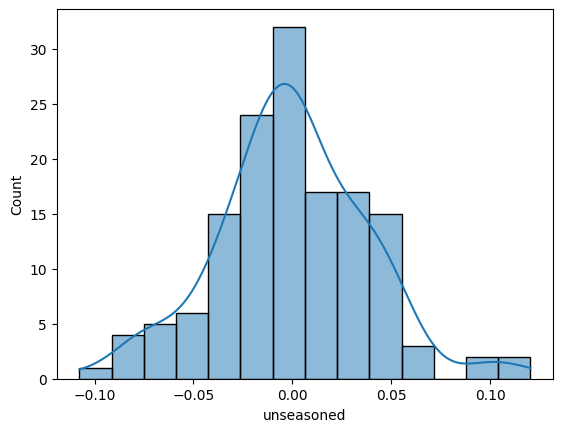

In [51]:
sns.histplot(data=df, x="unseasoned", kde=True)  # hard to say whether this is a bell curve (low number of points)

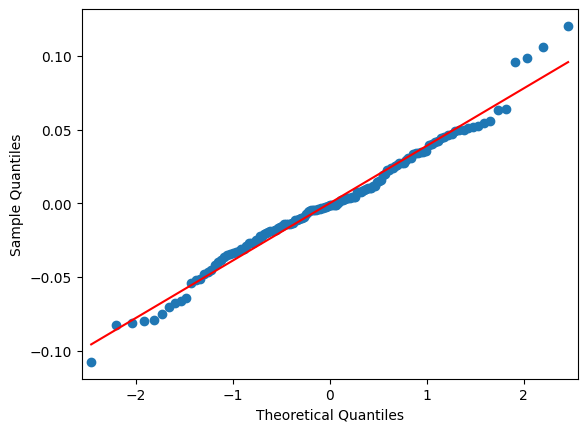

In [78]:
# QQ-plot
# a method to estimate whether data is normally distributed.
# The QQ-plot sorts the data and plots it against normally distributed random data.
# if the middle part of the data is more or less a straight line -> normally distributed
# here it is sort of ok, so we can conclude that it is close enough for a normal distribution
from statsmodels.graphics.gofplots import qqplot

_ = qqplot(df["unseasoned"].dropna(), line="r")

### Autocorrelation plot

A more sophisticated method to analyze whethere there is information left in the data.
The Autocorrelation function calculates the correlation coefficient between y(t) and y(t-1), then y(t) against y(t-2) and so on and plots all the correlation coefficients.

In [66]:
from statsmodels.graphics.tsaplots import plot_acf

In [61]:
from statsmodels.tsa.stattools import acf

In [64]:
acf(df["unseasoned"].dropna())

array([ 1.00000000e+00, -2.30172066e-01,  3.60081506e-02, -7.56344119e-02,
       -1.71406151e-01,  1.77325442e-02,  4.74415715e-02, -7.14443121e-02,
       -1.21547001e-01,  7.56550075e-02, -4.47038969e-02,  2.60615680e-02,
        1.48320867e-01,  3.11522691e-02, -7.46859645e-04,  7.61217446e-02,
       -2.07664226e-01,  3.39224288e-02,  9.68396274e-03, -7.06910682e-02,
       -7.85886304e-02, -4.35376072e-02])

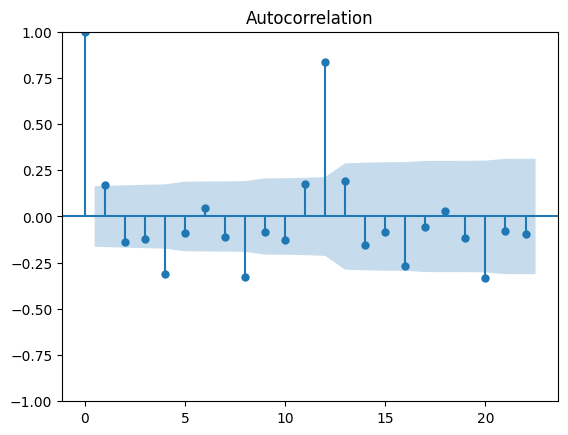

In [70]:
_ = plot_acf(df["pct"].dropna())  # clearly shows a signal for the yearly seasonal pattern

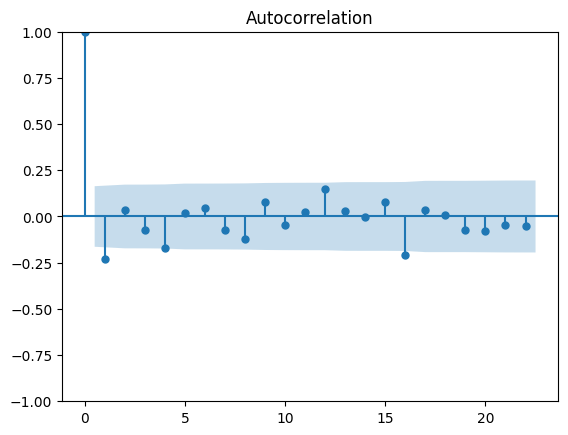

In [71]:
_ = plot_acf(df["unseasoned"].dropna())  # doesnt show anything

if there is a signal in the first few time lags on the x-axis: you could try prediction with a stronger model like ARIMA or exponential smoothing

### More info:

[Forecasting: Principles and Practice by Hyndman and Athanasopoulos](https://otexts.com/fpp3/)